In [1]:
import pandas as pd

In [2]:
df = pd.read_csv("../data/head_dataset_labeled.csv")
df.head()

,filename,page,group,era
0,page188_img01_photo13.jpg,188,SOUNION GROUP,615 - 590 BC
1,page196_img01_photo5.jpg,196,SOUNION GROUP,615 - 590 BC
2,page200_img01_photo7.jpg,200,SOUNION GROUP,615 - 590 BC
3,page202_img01_photo3.jpg,202,SOUNION GROUP,615 - 590 BC
4,page202_img01_photo4.jpg,202,SOUNION GROUP,615 - 590 BC


In [3]:
import torch
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from PIL import Image
import os
from transformers import AutoImageProcessor, Dinov2Model
from tqdm.notebook import tqdm # Import tqdm for progress bar


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Dinov2Model.from_pretrained("facebook/dinov2-base").to(device)
processor = AutoImageProcessor.from_pretrained("facebook/dinov2-base")

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.48, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [5]:
batch_size = 32
embeddings = []

image_directory = "../data/richter_kouroi_head_front_only"

# Collect filenames and eras for batching
filenames = df['filename'].tolist()
eras = df['era'].tolist()

for i in tqdm(range(0, len(filenames), batch_size), desc="Processing Images in Batches"):
    batch_filenames = filenames[i:i + batch_size]

    images = []
    valid_indices = []
    for j, filename in enumerate(batch_filenames):
        image_path = os.path.join(image_directory, filename)
        try:
            image = Image.open(image_path).convert('RGB')  # convert to RGB to avoid issues
            images.append(image)
            valid_indices.append(i + j)  # Keep track of valid indices for later
        except FileNotFoundError:
            print(f"Image not found at: {image_path}")
        except Exception as e:
            print(f"Error processing image {filename}: {e}")

    if len(images) == 0:
        continue  # Skip empty batches

    # Process the batch of images
    inputs = processor(images=images, return_tensors="pt").to(device)
    with torch.no_grad():
        outputs = model(**inputs)
    last_hidden_states = outputs.last_hidden_state

    # Mean pooling over patches per image in batch
    batch_embeddings = last_hidden_states.mean(dim=1).cpu().numpy()

    # Append embeddings maintaining order corresponding to valid images
    embeddings.extend(batch_embeddings)

embeddings = np.array(embeddings)
np.save('dinov2_image_embeddings.npy', embeddings)




Processing Images in Batches:   0%|          | 0/3 [00:00<?, ?it/s]

C:\Users\Kaiyan Zhang\AppData\Local\Temp\ipykernel_16612\3958630150.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', len(unique_eras))


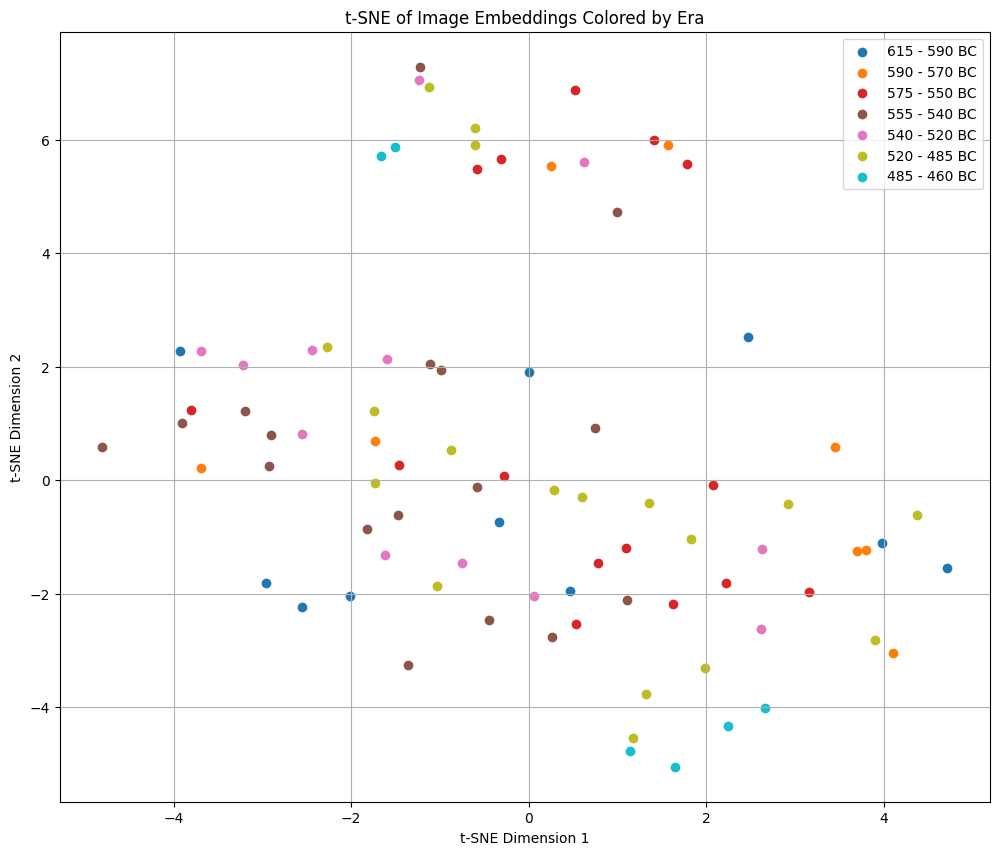

In [6]:
# Proceed with your t-SNE and plotting code...
tsne = TSNE(n_components=2, init='pca', method='exact')
tsne_embeddings = tsne.fit_transform(embeddings)

plt.figure(figsize=(12, 10))
unique_eras = df['era'].unique()
colors = plt.cm.get_cmap('tab10', len(unique_eras))

for i, era in enumerate(unique_eras):
    indices = df[df['era'] == era].index
    plt.scatter(tsne_embeddings[indices, 0], tsne_embeddings[indices, 1], color=colors(i), label=era)

plt.title('t-SNE of Image Embeddings Colored by Era')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.legend()
plt.grid(True)
plt.show()

In [7]:
!pip install plotly==5.14.0 --quiet

In [8]:
import plotly.express as px


In [9]:
# Create a DataFrame for Plotly
plotly_df = pd.DataFrame({
    'TSNE_Dim1': tsne_embeddings[:, 0],
    'TSNE_Dim2': tsne_embeddings[:, 1],
    'Era': df['era'].tolist(), # Use the 'era' column from your original df
    'Filename': df['filename'].tolist() # Include the filenames
})
fig = px.scatter(
        plotly_df,
        x='TSNE_Dim1',
        y='TSNE_Dim2',
        color='Era',
        hover_data=['Filename'], # Show filename when hovering
        title='Interactive t-SNE of Image Embeddings Colored by Era'
    )

fig.show()

c:\Users\Kaiyan Zhang\AppData\Local\Programs\Python\Python312\Lib\site-packages\plotly\express\_core.py:1983: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  sf: grouped.get_group(s if len(s) > 1 else s[0])


C:\Users\Kaiyan Zhang\AppData\Local\Temp\ipykernel_16612\119444610.py:10: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



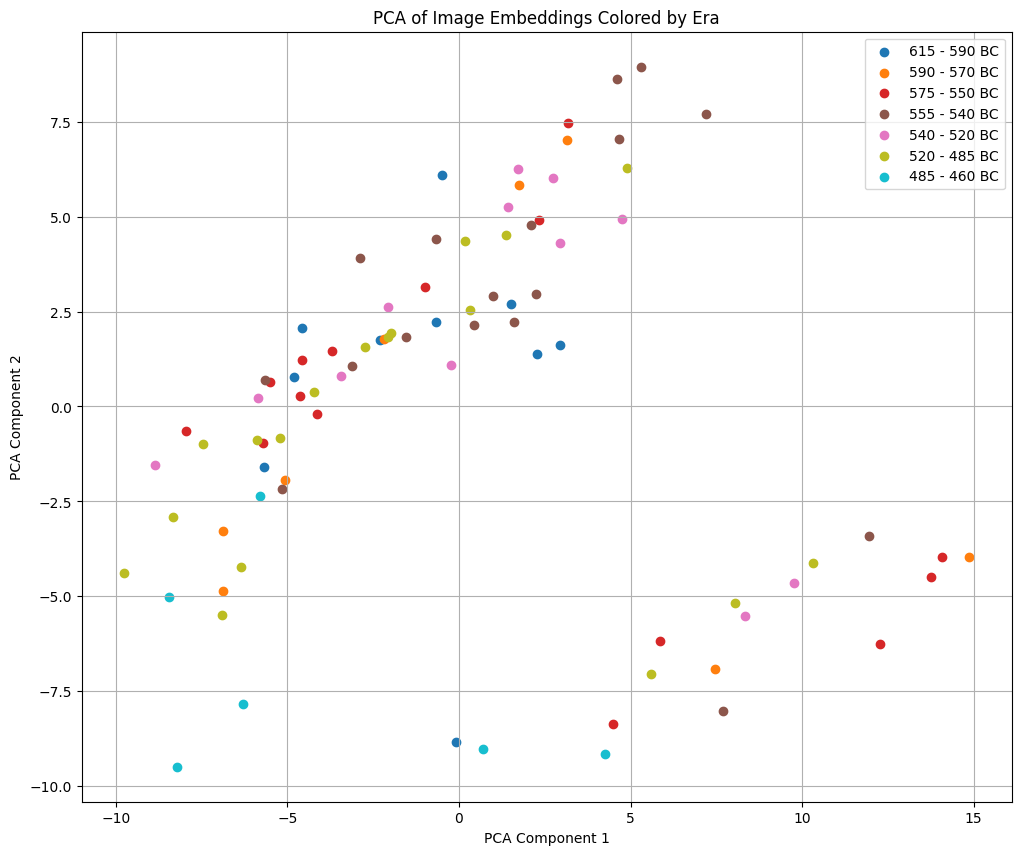

In [10]:
from sklearn.decomposition import PCA

# Perform PCA instead of t-SNE
pca = PCA(n_components=2)
pca_embeddings = pca.fit_transform(embeddings)

# Plot the PCA result
plt.figure(figsize=(12, 10))
unique_eras = df['era'].unique()
colors = plt.cm.get_cmap('tab10', len(unique_eras))

for i, era in enumerate(unique_eras):
    indices = df[df['era'] == era].index
    plt.scatter(pca_embeddings[indices, 0], pca_embeddings[indices, 1], color=colors(i), label=era)

plt.title('PCA of Image Embeddings Colored by Era')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.grid(True)
plt.show()


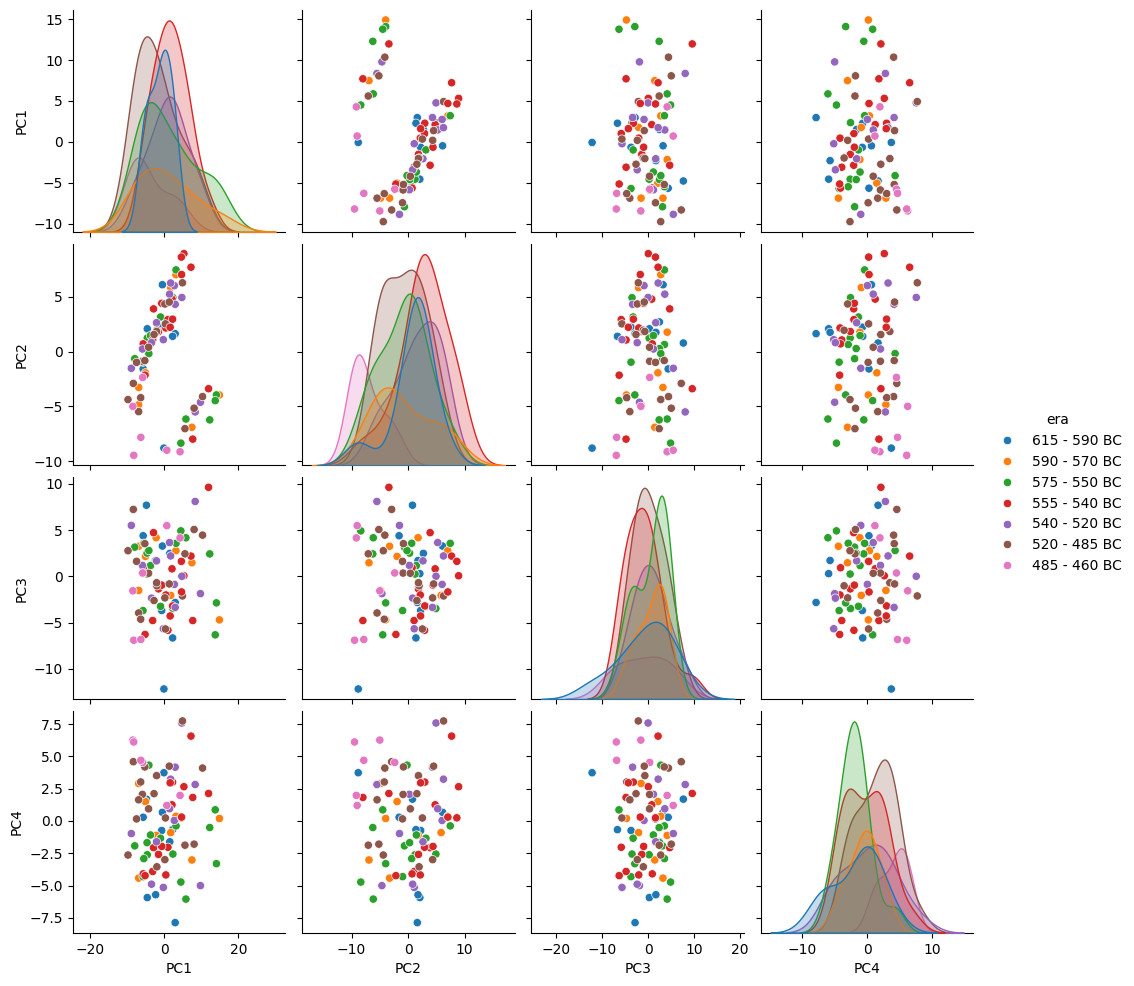

In [12]:
from sklearn.decomposition import PCA

# e.g. compute 5 principal components
pca = PCA(n_components=6)
pca_embeddings = pca.fit_transform(embeddings)
# now pca_embeddings.shape == (n_samples, 5)

pc_df = pd.DataFrame(
    pca_embeddings[:, :6],
    columns=['PC1','PC2','PC3','PC4', 'PC5', 'PC6']
)
pc_df['era'] = df['era'].values

import seaborn as sns
sns.pairplot(pc_df, hue='era', vars=['PC1','PC2','PC3','PC4'])
plt.show()



In [13]:
# Create a DataFrame for Plotly
plotly_df = pd.DataFrame({
    'TSNE_Dim1': pca_embeddings[:, 0],
    'TSNE_Dim2': pca_embeddings[:, 1],
    'Era': df['era'].tolist(), # Use the 'era' column from your original df
    'Filename': df['filename'].tolist() # Include the filenames
})
fig = px.scatter(
        plotly_df,
        x='TSNE_Dim1',
        y='TSNE_Dim2',
        color='Era',
        hover_data=['Filename'], # Show filename when hovering
        title='Interactive t-SNE of Image Embeddings Colored by Era'
    )

fig.show()

c:\Users\Kaiyan Zhang\AppData\Local\Programs\Python\Python312\Lib\site-packages\plotly\express\_core.py:1983: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



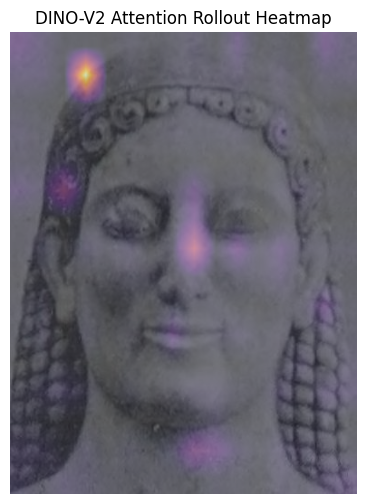

In [17]:
model = Dinov2Model.from_pretrained(
    "facebook/dinov2-base",
    output_attentions=True,   # <-- get all the self-attention weights
).eval().to(device)
processor = AutoImageProcessor.from_pretrained("facebook/dinov2-base")

img = Image.open("../data/richter_kouroi_head_front_only/page286_img01_photo3.jpg").convert("RGB")
inputs = processor(images=img, return_tensors="pt").to(device)

with torch.no_grad():
    outputs = model(**inputs)

# outputs.attentions: tuple of length L (num layers), each (batch=1, heads=H, seq_len=T, seq_len=T)
attns = [attn[0].mean(dim=0).cpu()  # average over heads
         for attn in outputs.attentions]

T = attns[0].size(-1)  # total tokens = 1 (CLS) + num_patches
rollout = torch.eye(T)

for layer_attn in attns:
    # Add identity (residual) and renormalize rows
    layer_aug = layer_attn + torch.eye(T)
    layer_aug = layer_aug / layer_aug.sum(dim=-1, keepdim=True)
    # Propagate
    rollout = layer_aug @ rollout

# Extract CLS → patch attentions (skip the CLS→CLS token at rollout[0,0])
patch_attn = rollout[0, 1:]  # shape: (num_patches,)

# Reshape to 2D grid
grid_size = int(np.sqrt(patch_attn.size(0)))
heatmap = patch_attn.reshape(grid_size, grid_size).numpy()

heatmap_tensor = torch.tensor(heatmap).unsqueeze(0).unsqueeze(0)  # (1,1,G,G)
heatmap_up = torch.nn.functional.interpolate(
    heatmap_tensor,
    size=img.size[::-1],      # (height, width)
    mode="bilinear",
    align_corners=False
)[0,0].numpy()

plt.figure(figsize=(6,6))
plt.imshow(img, alpha=0.8)
plt.imshow(heatmap_up, cmap="inferno", alpha=0.5)
plt.axis("off")
plt.title("DINO-V2 Attention Rollout Heatmap")
plt.show()


In [18]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import pandas as pd
from transformers import AutoImageProcessor, Dinov2Model
from tqdm.auto import tqdm


In [69]:

# ——————————————————————————————————————
# 1) Hyperparameters & paths
# ——————————————————————————————————————
IMAGE_DIR   = "../data/richter_kouroi_complete_front_only"
CSV_PATH    = "../data/complete_sculpture_dataset_labeled.csv"   # with columns ['filename','era']
BATCH_SIZE  = 32
LR          = 1e-3
EPOCHS      = 15
DEVICE      = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MODEL_NAME  = "facebook/dinov2-base"

# Map your era strings to integer labels
ERA2IDX = {
    '615 - 590 BC': 0,
    '590 - 570 BC': 1,
    '575 - 550 BC': 2,
    '555 - 540 BC': 3,
    '540 - 520 BC': 4,
    '520 - 485 BC': 5,
    '485 - 460 BC': 6,
}

MAT2IDX = {
    'Marble': 0,
    'Bronze': 1,
    'Lead': 2,
    'Alabaster': 3,
    'Limestone': 4,
    'Terracotta': 5,
}

In [79]:

# ——————————————————————————————————————
# 2) Dataset & DataLoader
# ——————————————————————————————————————
class KouroiEraDataset(Dataset):
    def __init__(self, csv_path, img_dir, processor, mat2idx):
        self.df = pd.read_csv(csv_path)
        self.img_dir = img_dir
        self.processor = processor
        self.mat2idx = MAT2IDX

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img = Image.open(os.path.join(self.img_dir, row.filename)).convert("RGB")
        # turn to model inputs
        inputs = self.processor(images=img, return_tensors="pt")
        # remove batch dim
        for k,v in inputs.items():
            inputs[k] = v.squeeze(0)
        label = self.mat2idx[row.material]
        return inputs, label

# Initialize processor + dataset
processor = AutoImageProcessor.from_pretrained(MODEL_NAME)
dataset = KouroiEraDataset(CSV_PATH, IMAGE_DIR, processor, MAT2IDX)
loader  = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)


In [ ]:

# ——————————————————————————————————————
# 3) Build model: frozen DINO + MLP head
# ——————————————————————————————————————
class EraClassifier(nn.Module):
    def __init__(self, backbone_name, num_classes):
        super().__init__()
        # load DINO‐V2 without gradient updates
        self.backbone = Dinov2Model.from_pretrained(
            backbone_name, output_hidden_states=False, output_attentions=False
        )
        for p in self.backbone.parameters():
            p.requires_grad = False

        embed_dim = self.backbone.config.hidden_size
        # a simple 2‑layer MLP head
        self.head = nn.Sequential(
            nn.Linear(embed_dim, embed_dim//2),
            nn.ReLU(inplace=True),
            nn.Dropout(0.2),
            nn.Linear(embed_dim//2, num_classes)
        )

    def forward(self, pixel_values):
        # pixel_values: (B,3,H,W)
        outputs = self.backbone(pixel_values=pixel_values)
        # mean‐pool the patch embeddings: (B, num_patches, D) → (B,D)
        x = outputs.last_hidden_state.mean(dim=1)
        logits = self.head(x)
        return logits

model = EraClassifier(MODEL_NAME, num_classes=len(MAT2IDX)).to(DEVICE)


In [81]:

# ——————————————————————————————————————
# 4) Training loop
# ——————————————————————————————————————
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.head.parameters(), lr=LR)  
# note: we only pass head.parameters() so backbone stays frozen

for epoch in range(1, EPOCHS+1):
    model.train()
    total_loss = 0
    for batch in tqdm(loader, desc=f"Epoch {epoch}/{EPOCHS}"):
        inputs, labels = batch
        # move to device
        inputs = {k:v.to(DEVICE) for k,v in inputs.items()}
        labels = labels.to(DEVICE)

        optimizer.zero_grad()
        logits = model(**inputs)
        loss   = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * labels.size(0)

    avg_loss = total_loss / len(dataset)
    print(f" Epoch {epoch} avg loss: {avg_loss:.4f}")


Epoch 1/15:   0%|          | 0/2 [00:00<?, ?it/s]

 Epoch 1 avg loss: 1.5357


Epoch 2/15:   0%|          | 0/2 [00:00<?, ?it/s]

 Epoch 2 avg loss: 0.9983


Epoch 3/15:   0%|          | 0/2 [00:00<?, ?it/s]

 Epoch 3 avg loss: 0.8323


Epoch 4/15:   0%|          | 0/2 [00:00<?, ?it/s]

 Epoch 4 avg loss: 0.5830


Epoch 5/15:   0%|          | 0/2 [00:00<?, ?it/s]

 Epoch 5 avg loss: 0.4432


Epoch 6/15:   0%|          | 0/2 [00:00<?, ?it/s]

 Epoch 6 avg loss: 0.3940


Epoch 7/15:   0%|          | 0/2 [00:00<?, ?it/s]

 Epoch 7 avg loss: 0.3297


Epoch 8/15:   0%|          | 0/2 [00:00<?, ?it/s]

 Epoch 8 avg loss: 0.2696


Epoch 9/15:   0%|          | 0/2 [00:00<?, ?it/s]

 Epoch 9 avg loss: 0.1759


Epoch 10/15:   0%|          | 0/2 [00:00<?, ?it/s]

 Epoch 10 avg loss: 0.1656


Epoch 11/15:   0%|          | 0/2 [00:00<?, ?it/s]

 Epoch 11 avg loss: 0.1141


Epoch 12/15:   0%|          | 0/2 [00:00<?, ?it/s]

 Epoch 12 avg loss: 0.0824


Epoch 13/15:   0%|          | 0/2 [00:00<?, ?it/s]

 Epoch 13 avg loss: 0.0646


Epoch 14/15:   0%|          | 0/2 [00:00<?, ?it/s]

 Epoch 14 avg loss: 0.0565


Epoch 15/15:   0%|          | 0/2 [00:00<?, ?it/s]

 Epoch 15 avg loss: 0.0493


<Figure size 800x800 with 0 Axes>

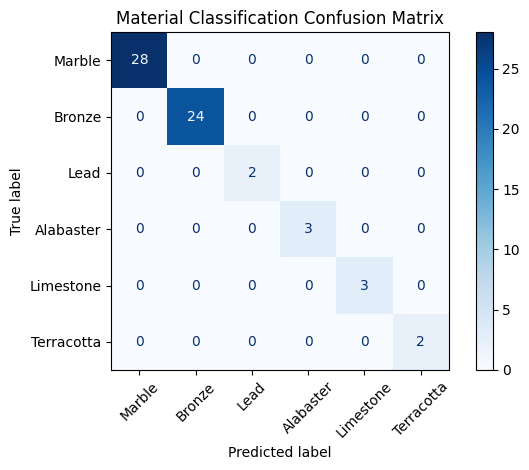

In [82]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# 1) Run one pass over your data in eval mode
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for inputs, labels in loader:
        if inputs is None: continue
        inputs = {k:v.to(DEVICE) for k,v in inputs.items()}
        logits = model(**inputs)
        all_preds.extend(logits.argmax(dim=1).cpu().numpy())
        all_labels.extend(labels.numpy())

# 2) Compute & plot
cm = confusion_matrix(all_labels, all_preds, labels=list(MAT2IDX.values()))
disp = ConfusionMatrixDisplay(cm, display_labels=list(MAT2IDX.keys()))
plt.figure(figsize=(8,8))
disp.plot(cmap="Blues", xticks_rotation=45, values_format="d")
plt.title("Material Classification Confusion Matrix")
plt.tight_layout()
plt.show()


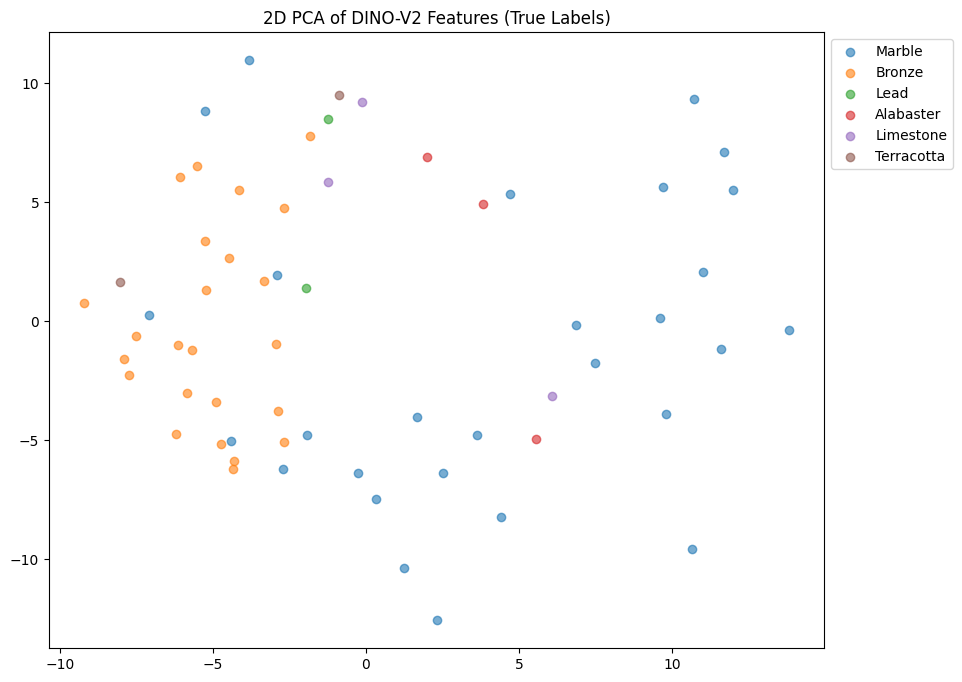

In [83]:
features, preds, labels = [], [], []
model.eval()
with torch.no_grad():
    for inputs, labs in loader:
        if inputs is None: continue
        inputs = {k:v.to(DEVICE) for k,v in inputs.items()}
        out = model.backbone(pixel_values=inputs['pixel_values'])
        emb = out.last_hidden_state.mean(1).cpu().numpy()
        features.append(emb)
        logits = model.head(torch.from_numpy(emb).to(DEVICE))
        preds.extend(logits.argmax(dim=1).cpu().numpy())
        labels.extend(labs.numpy())

features = np.vstack(features)  # shape (N, D)

from sklearn.decomposition import PCA
pca = PCA(n_components=2)
feat2d = pca.fit_transform(features)

plt.figure(figsize=(10,8))
for idx, material in enumerate(MAT2IDX.keys()):
    mask = np.array(labels) == idx
    plt.scatter(feat2d[mask,0], feat2d[mask,1],
                label=material, alpha=0.6)
plt.legend(bbox_to_anchor=(1,1))
plt.title("2D PCA of DINO-V2 Features (True Labels)")
plt.show()


<Figure size 600x600 with 0 Axes>

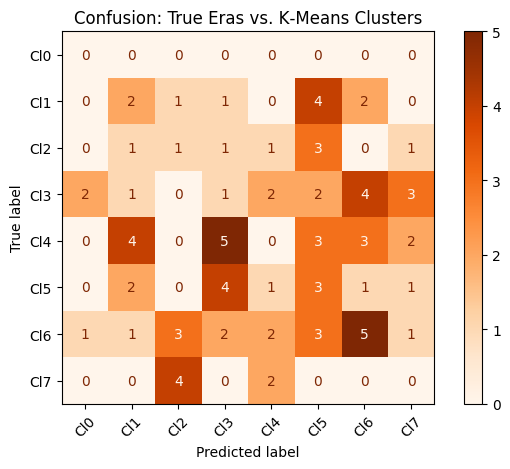

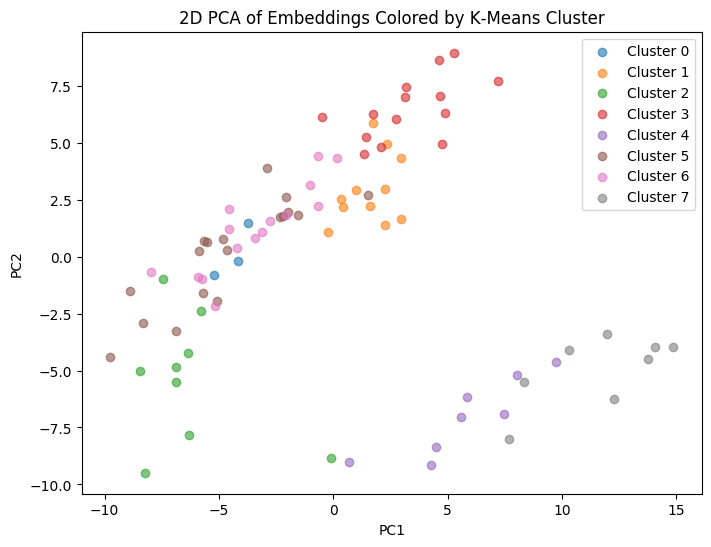

In [57]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from torch.utils.data import DataLoader

# 1) Prepare DataLoader (reuse your existing dataset & processor)
dataset = KouroiEraDataset(CSV_PATH, IMAGE_DIR, processor, ERA2IDX)
loader  = DataLoader(dataset, batch_size=32, shuffle=False, num_workers=0)

# 2) Extract embeddings
model.backbone.eval()
all_feats, all_eras = [], []
with torch.no_grad():
    for batch in loader:
        if batch is None: 
            continue
        inputs, labels = batch
        inputs = {k:v.to(DEVICE) for k,v in inputs.items()}
        out = model.backbone(pixel_values=inputs['pixel_values'])
        # (B, num_patches, D) → (B, D)
        embs = out.last_hidden_state.mean(dim=1).cpu().numpy()
        all_feats.append(embs)
        all_eras.extend(labels.numpy())

all_feats = np.vstack(all_feats)   # shape (N_images, D)
all_eras  = np.array(all_eras)     # shape (N_images,)

# 3) (Optional) PCA to 50 dims for faster, denoised clustering
pca50 = PCA(n_components=50)
feats50 = pca50.fit_transform(all_feats)

# 4) Fit K‑Means (8 clusters)
n_clusters = 8
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
clusters = kmeans.fit_predict(feats50)

# 5) Confusion between cluster IDs and true eras
cm = confusion_matrix(all_eras, clusters, labels=list(ERA2IDX.values()))
disp = ConfusionMatrixDisplay(
    cm, display_labels=[f"Cl{c}" for c in range(n_clusters)]
)
plt.figure(figsize=(6,6))
disp.plot(cmap="Oranges", xticks_rotation=45)
plt.title("Confusion: True Eras vs. K‑Means Clusters")
plt.tight_layout()
plt.show()

# 6) Visualize clusters in 2D PCA space
pca2 = PCA(n_components=2)
feats2 = pca2.fit_transform(all_feats)

plt.figure(figsize=(8,6))
for cl in range(n_clusters):
    mask = clusters == cl
    plt.scatter(feats2[mask,0], feats2[mask,1],
                label=f"Cluster {cl}", alpha=0.6)
plt.legend(bbox_to_anchor=(1,1))
plt.title("2D PCA of Embeddings Colored by K‑Means Cluster")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.show()


In [ ]:

# ——————————————————————————————————————
# 5) (Optional) Save your head
# ——————————————————————————————————————
torch.save(model.head.state_dict(), "dino2_era_head.pt")
print("⭐ Saved MLP head to dino2_era_head.pt")
